In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time
import matplotlib

sys.path.append('../code/')
from interpolation import cfl_interpolation, cfl_interpolation5
from diusst_eulera import diusst_eulera
from diusst_eulerb import diusst_eulerb
from diusst_rk4a import diusst_rk4a
from diusst_rk4b import diusst_rk4b
from diusst_eulerc import diusst_eulerc

from diusst_funcs import make_mesh
from mscfunctions import fresnel

In [35]:
times_orig = np.linspace(0,2*86400,2*24*60)
len(times)

2880

In [36]:
# Incoming SW radiation
def q_sw(t, a, reflect=1, n_a=1., n_w=1.34):
    if reflect == 1:
        return a * np.cos(2*np.pi*t/(60*60*24)+np.pi) * fresnel(2*np.pi*t/(60*60*24)+np.pi, n1=n_a, n2=n_w)
    elif reflect == 0:
        return a * np.cos(2*np.pi*t/(60*60*24)+np.pi)

# Boundary layer air temperature
def T_a(t, Tmax, Tmin, tau=0):
    return (Tmax+Tmin)/2 - (Tmax-Tmin)/2 * np.cos(2*np.pi/(60*60*24)*(t-tau))

In [37]:
swrad_orig = q_sw(times_orig,1)*1000
atemp_orig = T_a(times_orig,301,299)
wind_orig = 2 + 1*np.cos(times_orig/86400*2*np.pi)
humid_orig = np.ones(len(times_orig)) * 0.01
ftemp_orig = np.ones(len(times_orig)) * 300
sst_orig = np.zeros(len(times_orig))
sst_err_orig = np.ones(len(times_orig)) * 0.1

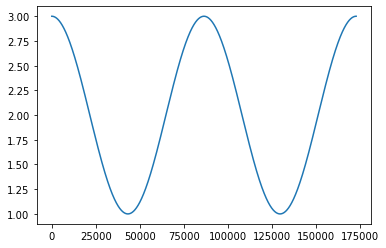

In [39]:
plt.plot(times_orig,wind_orig)


In [40]:
# Fit parameters
param_names = ['kappa', 'mu', 'attenu', 'k0', 'gamma']
parama = np.array([1e-4, 1e-4, 2.5])
paramb = np.array([3e-4, 1e-4, 2.5])
paramc = np.array([2e-4, 1e-4, 2.5, 0.95, 2])
param_max = np.array([10e-4, 1e-4, 2.5])

# DIUSST model
scheme = 'euler'
dz0 = 0.10
ngrid = 40
z_f = 10
diffu = 1
opac = 1
k_mol = 1e-7
maxwind = 10

In [41]:
data_array = np.stack([times_orig, wind_orig, atemp_orig, swrad_orig, humid_orig,sst_orig,sst_err_orig,ftemp_orig])
colnames = ['times','wind','atemp','swrad','humid','sst','sst_err','ftemp']
data_orig = pd.DataFrame(data_array.transpose(),columns=colnames)

In [42]:
data_orig

,times,wind,atemp,swrad,humid,sst,sst_err,ftemp
0,0.000000,3.000000,299.000000,-5.551115e-13,0.01,0.0,0.1,300.0
1,60.020841,2.999990,299.000010,-5.551062e-13,0.01,0.0,0.1,300.0
2,120.041681,2.999962,299.000038,-5.550904e-13,0.01,0.0,0.1,300.0
3,180.062522,2.999914,299.000086,-5.550639e-13,0.01,0.0,0.1,300.0
4,240.083362,2.999848,299.000152,-5.550269e-13,0.01,0.0,0.1,300.0
...,...,...,...,...,...,...,...,...
2875,172559.916638,2.999848,299.000152,-5.550269e-13,0.01,0.0,0.1,300.0
2876,172619.937478,2.999914,299.000086,-5.550639e-13,0.01,0.0,0.1,300.0
2877,172679.958319,2.999962,299.000038,-5.550904e-13,0.01,0.0,0.1,300.0
2878,172739.979159,2.999990,299.000010,-5.551062e-13,0.01,0.0,0.1,300.0


## Model

In [55]:
k_eddy=0.0001; mu=0.005; attenu=4; k0=.8; gamma=2

# interpolate to meet CFL condition
data, dtlist, idx = cfl_interpolation5(data_orig, dz0=dz0, ngrid=ngrid,
        k_mol = k_mol,
        k_eddy_max=k_eddy, k_0_min=k0, lambd_min=gamma,
        maxwind=maxwind, z_f=z_f)


# extract data
ftemp = np.mean(data['ftemp'].to_numpy(np.float64))
sst_data = data['sst'].to_numpy(np.float64) - data['ftemp'].to_numpy(np.float64)
sst_err = data['sst_err'].to_numpy(np.float64)
times = data['times'].to_numpy(np.float64)
wind = data['wind'].to_numpy(np.float64)
atemp = data['atemp'].to_numpy(np.float64)
atemp_rel = atemp - data['ftemp'].to_numpy(np.float64) + ftemp
swrad = data['swrad'].to_numpy(np.float64)
humid = data['humid'].to_numpy(np.float64)

+++ Variable time-step interpolation +++
Interpolated dataset has 20153 time steps with average length 10.0 s.
Constant dt interpolation would require dt = 10.526 s --> 18189 steps.
Computation time will be reduced by -10.798 %
++++++++++++++++++++++++++++++++++++++++


0.5982446670532227
-3.0452936687931453


[Text(0.5, 1.0, 'SST-ftemp')]

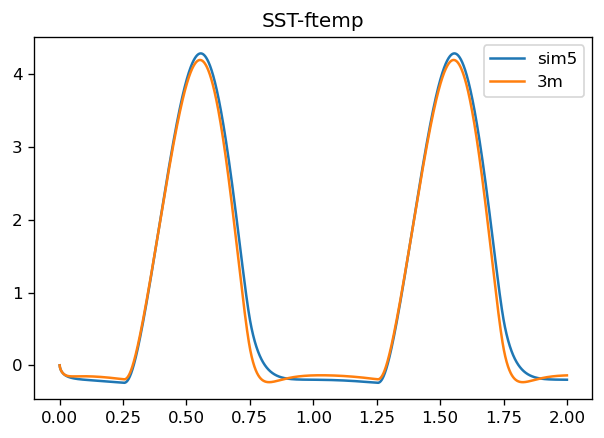

In [56]:
timer = time.time()
sim5 = diusst_eulerc(
                times, atemp_rel, swrad, u_data=wind, sa_data=humid, T_f=ftemp,
                k_eddy=k_eddy, mu=mu, attenu=attenu, k0=k0, gamma=gamma,
                opac=opac, k_mol=k_mol,
                dz=dz0, ngrid=ngrid)
print(time.time()-timer)

fig, ax = plt.subplots(dpi=120)
#ax.plot(times/86400,sst_data,'.',c='gray', label='Data')
#ax.plot(times/86400,sim1[0][:,0]-ftemp,label='sim1')
#ax.plot(times/86400,sim2[0][:,0]-ftemp,'--',label='sim2')
#ax.plot(times/86400,sim3[0][:,0]-ftemp,'--',label='sim3')
#ax.plot(times/86400,sim4[0][:,0]-ftemp,label='sim4')
ax.plot(times/86400,sim5[0][:,0]-ftemp,label='sim5',)
ax.plot(times/86400,sim5[0][:,0]-sim5[0][:,20],label='3m')
print(sim5[1][20])

ax.legend()
ax.set(title='SST-ftemp')

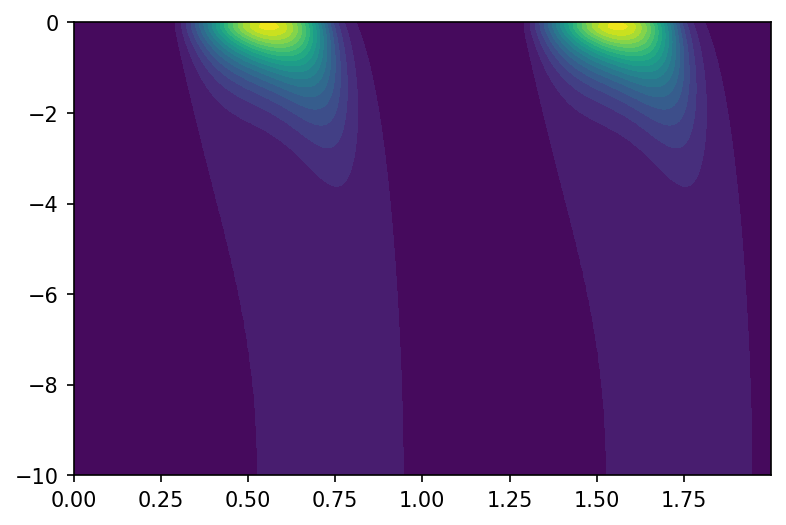

In [57]:
fig, ax = plt.subplots(dpi=150)
ax.contourf(sim5[2]/86400,sim5[1],sim5[0].transpose(),levels=20)

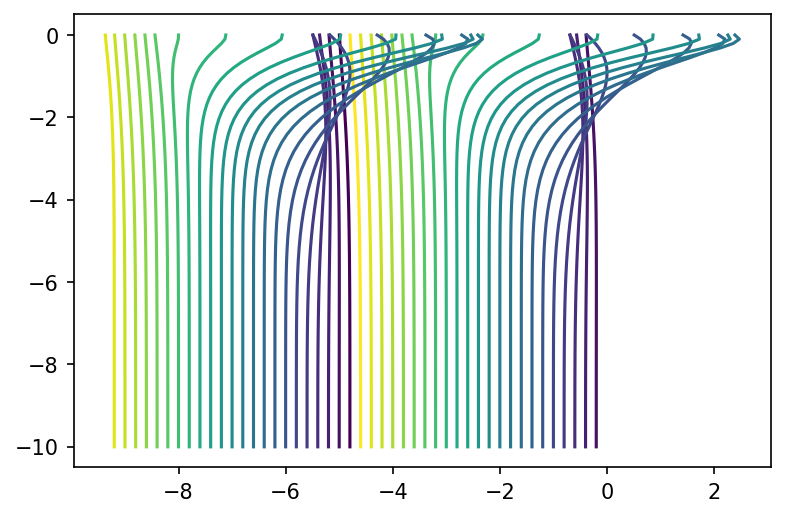

In [58]:
# hourly profile
t_hour = np.floor(sim5[2]/3600)
idx_fullhour = np.where(t_hour[1:]-t_hour[:-1]==1)[0]

c = (np.arange(len(idx_fullhour))) % 24

cols = matplotlib.cm.viridis(np.linspace(0,1,24))
fig, ax = plt.subplots(dpi=150)
for i in range(1,len(idx_fullhour)):
    ax.plot(sim5[0][-idx_fullhour[i],:]-0.2*i-ftemp,sim5[1],c=cols[(c[i])%24])